<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/07-autoencoding-and-self-supervision/03_autoregressive_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Autoregressive model

In this notebook, we shows that bread-and-butter
principal component analysis (PCA) works by secretly being an autoencoder.

We’ll make small changes to a PyTorch version of PCA to change it into a fully fledged
autoencoding neural network. 

As we make an autoencoding network larger, it becomes
more important to constrain it well, which we demonstrate with the denoising strategy.

Finally we apply these concepts to sequential models like RNNs, which gives the autoregressive model.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, View, weight_reset, set_seed

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We will use text from Shakespeare that are about 100,000 characters in this text.

In [6]:
all_data = []

response = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = response.read()
shakespear_100k = shakespear_100k.decode("utf-8").lower()

Now we will build a vocabulary $\Sigma$ of all the characters in this dataset.

In [18]:
# vocabulary
vocab2indx = {}

for char in shakespear_100k:
  # add every new character to the vocab
  if char not in vocab2indx:
    # set the index based on the current vocab size
    vocab2indx[char] = len(vocab2indx)

# reverse vocabulary to go from index back to original characters
index2vocab = {}

# Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping.
for k, v in vocab2indx.items():
  index2vocab[v] = k

print(f"Vocab Size: {len(vocab2indx)}")
print(f"Total Characters: {len(shakespear_100k)}")

Vocab Size: 36
Total Characters: 99993


Next we take a very simple approach to build an autoregressive dataset.

In [8]:
class AutoRegressiveDataset(Dataset):
  """
  Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks".
  """
  def __init__(self, large_string, MAX_CHUNK=500):
    """
    large_string: the original long source sequence that chunks will be extracted from
    MAX_CHUNK: the maximum allowed size of any chunk. 
    """
    self.doc = large_string
    self.MAX_CHUNK = MAX_CHUNK 

  def __len__(self):
    # The number of items is the number of characters divided by chunk size
    return (len(self.doc) - 1) // self.MAX_CHUNK

  def __getitem__(self, idx):
    # Compute the starting position for the idx'th chunk
    start = idx * self.MAX_CHUNK
    # Grab the input sub-string
    sub_string = self.doc[start: start + self.MAX_CHUNK]
    # convert the sub-string into integers based on our vocab
    x = [vocab2indx[c] for c in sub_string]

    # grab the label sub-string by shifting over by 1
    sub_string = self.doc[start + 1: start+ self.MAX_CHUNK + 1]
    # convert the label sub-string into integers based on our vocab
    y = [vocab2indx[c] for c in sub_string]

    # Converts the label substring into integers based on our vocab
    return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

##Autoregressive models for sequences

The autoencoding approach has been very successful for images, signals, and even
fully connected models with tabular data. But what if our data is a sequence problem?
Especially if our data is in a language represented by discrete tokens, it’s hard to add
meaningful noise to things like a letter or word. 

Instead, we can use an **autoregressive
model**, which is an approach specifically designed for time-series problems.

You can use an autoregressive model for basically all the same applications for which
you might use an autoencoding one. You can use the representation an autoregressive
model learns as the input to another ML algorithm that doesn’t understand sequences

Let’s say you have %t% steps of your data: $x_1, x_2, ..., x_{t-1}, x_{t}$. The goal of an autoregressive model is to predict $x_{t+1}$ given all the previous items in the sequence.

The autoregressive approach is still a form of self-supervision because the next item in
a sequence is a trivial component of having the data in the first place. 

If you treat the
sentence “This is a sentence” as a sequence of characters, you, by definition, know that
`T` is the first item, `h` the second, `i` the third, and so on.

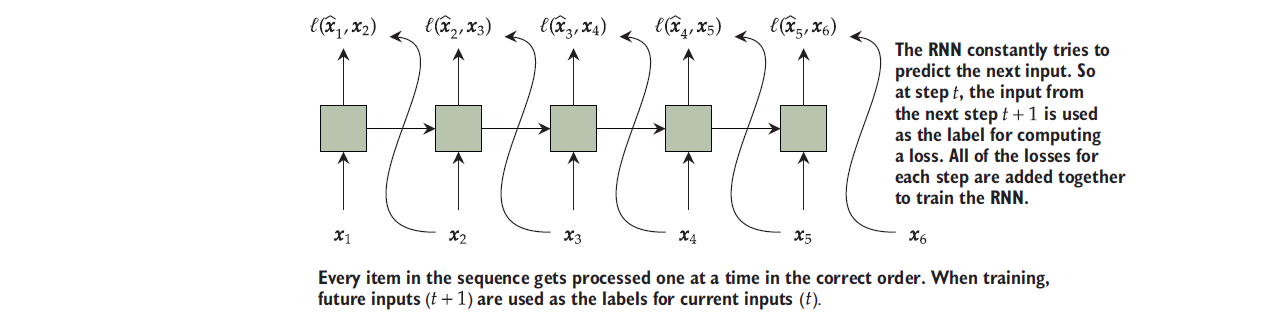

The prediction at
the ith step is thus $\hat x_i$. We then use the loss function $l$ to compute the loss between the
current prediction $\hat x_i$ and the next input $x_{i+1}, l(\hat x_i, x_{i+1})$. 

So for an input with `T` time
steps, we have `T - 1` loss calculations: the last time step `T` can’t be used as an input
because there is no `T + 1th` item to compare it against.

RNNs are great for sequence-based
problems like this one, But there is diffrence is that we will make a prediction at every step, instead of just the last step.

>While RNNs are an appropriate and common architecture to use for autoregressive
models, bidirectional RNNs are not. This is because an autoregressive
model is making predictions about the future. If we used a bidirectional model, we would have information about the future content in the sequence, and knowing
the future is cheating!

##char-RNN autoregressive text model

Now comes the tricky part: implementing an autoregressive RNN model. For this we
use a gated recurrent unit (GRU).

Let’s define some basic hyperparameters.

In [9]:
D = 28 * 28       # input size
n = 2             # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

In [10]:
class AutoRegressive(nn.Module):

  def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
    super(AutoRegressive, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(num_embeddings, embd_size)
    # GRUCell processes sequences one item at a time
    self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + [nn.GRUCell(hidden_size, hidden_size) for _ in range(layers - 1)])
    self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(layers)])

    self.prediction_class = nn.Sequential(
      nn.Linear(hidden_size, hidden_size),      # (B, *, D)
      nn.LeakyReLU(),
      nn.LayerNorm(hidden_size),                # (B, *, D)
      nn.Linear(hidden_size, num_embeddings)    # (B, *. D) -> B(B, *, VocabSize)
    )

  def forward(self, input_x):
    # input_x should be (B, T)
    B = input_x.size(0)   # What is the batch size?
    T = input_x.size(1)   # What is the max number of time steps?

    x = self.embedding(input_x)  # (B, T, D)

    # Initial hidden states
    h_prevs = self.init_hidden_states(B)

    last_activations = []
    for t in range(T):
      x_in = x[:, t, :]   # (B, D)
      last_activations.append(self.step(x_in, h_prevs))

    last_activations = torch.stack(last_activations, dim=1) # (B, T, D)
    return last_activations

  def init_hidden_states(self, B):
    """
    Creates an initial hidden state list for the RNN layers. 
    B: the batch size for the hidden states.
    """
    return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

  def step(self, x_in, h_prevs=None):
    """
    x_in: the input for this current time step and has shape (B) if the values need 
        to be embedded, and (B, D) if they have alreayd been embedded. 

    h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each 
        layer in the network. These contain the current hidden state of the RNN layers and 
        will be updated by this call.
    """
    # Prepare all three arguments to be in the final form
    if len(x_in.shape) == 1:       # (B), we need to embed it
      x_in = self.embedding(x_in)  # now (B, D)

    if h_prevs is None:
      h_prevs = self.init_hidden_states(x_in.shape[0])

    # Process the input 
    for layer in range(len(self.layers)):
      h_prev = h_prevs[layer]
      # Pushes in the current input with previous hidden states
      h = self.norms[layer](self.layers[layer](x_in, h_prev))

      h_prevs[layer] = h
      x_in = h

    # Make predictions about the token
    return self.prediction_class(x_in)

With our model defined, we are almost finished.

Let's quickly create our new `AutoRegressiveDataset` and AutoRegressive model.

In [11]:
auto_reg_data = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
auto_reg_dataloader = DataLoader(auto_reg_data, batch_size=128, shuffle=True)

auto_reg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
auto_reg_model = auto_reg_model.to(device)

for p in auto_reg_model.parameters():
  p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

Since we have multiple losses to compute, one for every time step. We can solve this by writing our own loss function CrossEntLossTime that computes the cross-entropy for each step.

In [12]:
def CrossEntLossTime(x, y):
  """
  x: output with shape (B, T, V)
  y: labels with shape (B, T)
  """
  cross_entropy_loss = nn.CrossEntropyLoss()

  T = x.size(1)
  loss = 0
  for t in range(T):  # for every item in the sequence
    # Compute the sum of prediction errors
    loss += cross_entropy_loss(x[:, t, :], y[:, t])
  return loss

In [ ]:
# Let's train this model
train_network(auto_reg_model, CrossEntLossTime, auto_reg_dataloader, epochs=100, device=device)

## Autoregressive models are generative models

Autoregressive models are not only self-supervised; they also fall into a class known as
generative models. 

This means they can generate new data that looks like the original data
it was trained on. 

To do this, we switch our model to eval mode and create a tensor
sampling that stores our generated output. 

Any output generated from a model can be
called a sample, and the process of generating that sample is called sampling.

In [15]:
auto_reg_model = auto_reg_model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

To sample from an autoregressive model, we usually need to give the model a seed. 

This is some original text that the model is given; then the model is asked to make predictions
about what comes next.

In [16]:
# Let's define our initial seed
seed = "EMILIA:".lower()
current_len = len(seed)

sampling[0, 0: current_len] = torch.tensor([vocab2indx[x] for x in seed])

Our model is making a prediction about
the probability of seeing every different character as the next possible output. 

But the next input needs to be a specific character. This can be done by sampling the predictions
based on the model’s output probabilities.

In [17]:
for i in tqdm(range(current_len, sampling.size(1))):
  with torch.no_grad():
    h = auto_reg_model(sampling[:, 0: i])   # process all the previous items
    h = h[:, -1, :]                         # Grab the last time step
    h = F.softmax(h, dim=1)                 # make probabilities
    next_tokens = torch.multinomial(h, 1)   # sample the next prediction
    sampling[:, i] = next_tokens            # set the next prediction
    current_len +=1                         # increase the length by one

  0%|          | 0/493 [00:00<?, ?it/s]

Now we have a new sequence that we have predicted, but what does it look like? 

That is why we saved an inverse mapping from tokens back to our vocabulary with the `indx2vocab`
dict: we can use that to map each integer back to a character, and then join them
together to create an output.

In [19]:
s = [index2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
tooken thee,
good rarther man fruct see and weot, the giver innot nows not that words togeing in so dainow lo;
m: the shall sing within good thysuy.

oparales:
and tertherry cuptunts,
bur, puntss and getnon bufel make; it mlegnt; thereple, and friend
there''d
moarmant me has bellat-srumentless terbot
did
parcessoot,
and, rity peach trusinup to city: i am hassell: meech sir.

gthance yor?

ratiesparus:
wambet's do
forther,ueland my hand flies: love a villold,
and thy trut's of therery is 


You should notice a few things about the output of our generation. While it kind of
looks Shakespearian, it quickly devolves. 

This is because with each step of the data, we
get further from real data, and our model will make unrealistic choices that thus become
errors and negatively impact future predictions. 

So the longer we generate, the lower
the quality will become.

##Changing samples with temperature